In [1]:
'''
Example of tensorflow(keras)-based distance driven 2d forward and backprojection
'''

'\nExample of tensorflow(keras)-based distance driven 2d forward and backprojection\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import tensorflow as tf
import os
import tensorflow.keras.backend as K

2023-01-03 05:23:00.779815: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import ct_projector.projector.tensorflow as ct_projector_tf
import ct_projector.projector.tensorflow.circular_2d as ct_circular_tf
import ct_projector.projector.tensorflow.filters as ct_filters_tf

2023-01-03 05:23:02.027536: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2023-01-03 05:23:02.126718: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-03 05:23:02.127818: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-03 05:23:02.161802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 05:23:02.162222: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-01-03 05:23:02.162243: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-01-03 05:23:02.165145: I tensorflow/stream_executor/platform/defau

In [5]:
# load a sample CT image
filename = './3.nii.gz'
ct = sitk.ReadImage(filename)
spacing = ct.GetSpacing()
img = sitk.GetArrayFromImage(ct)

# convert image from HU to attenuation coefficient
# This is the approximate relationship
img = (img.astype(np.float32) + 1024) / 1000 * 0.019
img[img < 0] = 0

img = img[200:232]

# also convert to image to our projector dimension batch, z, y, x
img = img[::-1, ...]
spacing = np.array(spacing[::-1])

vmin = -350 / 1000 * 0.019
vmax = 1150 / 1000 * 0.019

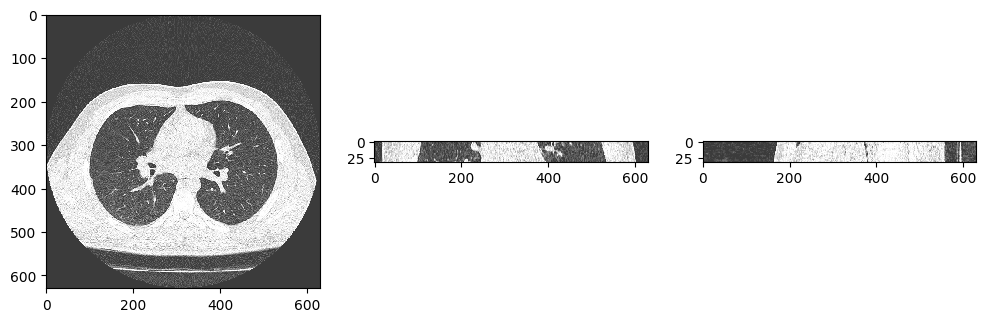

In [6]:
# show the ct images
plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(img[img.shape[0]//2, ...], 'gray', aspect=spacing[1] / spacing[2], vmin=vmin, vmax=vmax)
plt.subplot(132); plt.imshow(img[:, img.shape[1]//2, :], 'gray', aspect=spacing[0] / spacing[2], vmin=vmin, vmax=vmax)
plt.subplot(133); plt.imshow(img[..., img.shape[2]//2], 'gray', aspect=spacing[0] / spacing[1], vmin=vmin, vmax=vmax)

The projector holds the default parameters for the forward and backprojection. 

However, all the projection parameters are passed during calculation to enable training with various geometry. The only constraint is that within one batch the input images must be of the same shape, otherwise they cannot be passed as tensors `[batch, nx, ny, nz, channel]`. The output images must also have the same shapes. 

In [7]:
# setup the projector
projector = ct_projector_tf.ct_projector()
projector.from_file('./projector_fan.cfg')
projector.nx = img.shape[2]
projector.ny = img.shape[1]
projector.nz = 1
projector.dx = spacing[2]
projector.dy = spacing[1]
projector.dz = spacing[0]
projector.nv = 1
projector.nview = 768

angles = projector.get_angles()

for k in vars(projector):
    print (k, '=', getattr(projector, k))

nview = 768
rotview = 720
nu = 736
nv = 1
nx = 630
ny = 630
nz = 1
dx = 0.6835939884185791
dy = 0.6835939884185791
dz = 1.0
cx = 0
cy = 0
cz = 0
dsd = 1086.5
dso = 595.0
du = 1.2858
dv = 1.0
off_u = -1.125
off_v = 0
geometry = <configparser.ConfigParser object at 0x7f3bd980dd60>


In [8]:
img_input = img[:, np.newaxis, :, :, np.newaxis]
input_tensor = tf.convert_to_tensor(img_input, tf.float32)
print(input_tensor.shape)

fp_model = ct_circular_tf.DistanceDriven2DFP(
    projector,
    angles,
    ct_circular_tf.TypeGeometry.PARALLEL,
    ct_circular_tf.TypeProjector.IR,
)

bp_model = ct_circular_tf.DistanceDriven2DBP(
    projector,
    angles,
    ct_circular_tf.TypeGeometry.PARALLEL,
    ct_circular_tf.TypeProjector.FORCE_FBP,
)

filter_model = ct_filters_tf.ProjectionFilter(
    projector.du,
    ct_circular_tf.TypeGeometry.PARALLEL,
    ct_filters_tf.TypeFilter.RL
)


(32, 1, 630, 630, 1)


2023-01-03 05:23:08.252368: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-03 05:23:08.254941: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-03 05:23:08.255153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 05:23:08.255608: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-01-

In [9]:
with tf.GradientTape() as t:
    t.watch(input_tensor)
    fp_tensor = fp_model(input_tensor)
    loss = tf.reduce_sum(fp_tensor * fp_tensor / 2)
grad_tensor = t.gradient(loss, input_tensor)

fprj_tensor = filter_model(fp_tensor)
bp_tensor = bp_model(fprj_tensor)

print(fp_tensor.shape)
print(bp_tensor.shape)
print(grad_tensor.shape)

2023-01-03 05:23:09.683935: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2023-01-03 05:23:09.948503: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-01-03 05:23:10.316096: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


(32, 768, 1, 736, 1)
(32, 1, 630, 630, 1)
(32, 1, 630, 630, 1)


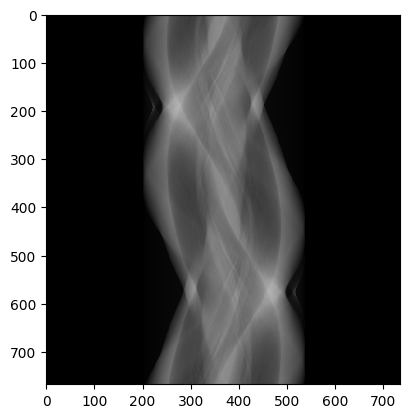

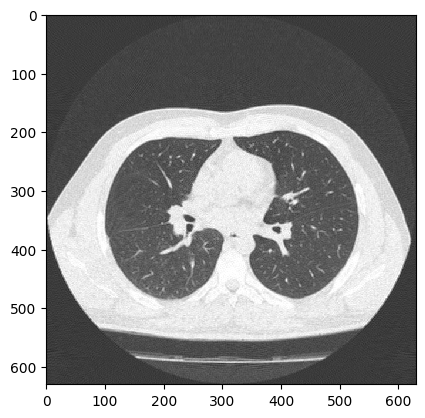

In [10]:
fp = fp_tensor.numpy()
plt.figure()
plt.imshow(fp[fp.shape[0] // 2, :, 0, :, 0], 'gray', vmin=0, vmax=10)

bp = bp_tensor.numpy()
plt.figure()
plt.imshow(bp[bp.shape[0] // 2, 0, :, :, 0], 'gray', vmin=vmin, vmax=vmax)

2915.396


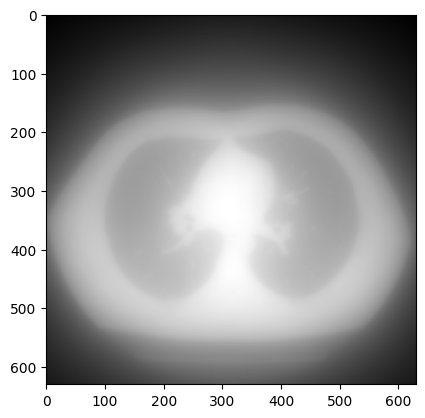

In [11]:
grad = grad_tensor.numpy()
print(np.abs(grad - bp).max())
plt.imshow(grad[grad.shape[0] // 2, 0, :, :, 0], 'gray')

0.0
0.00957272


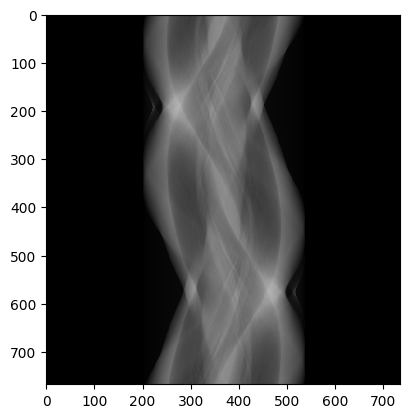

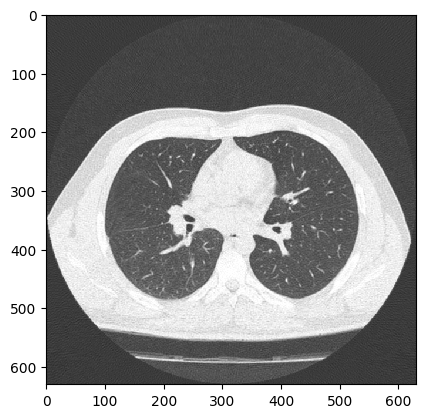

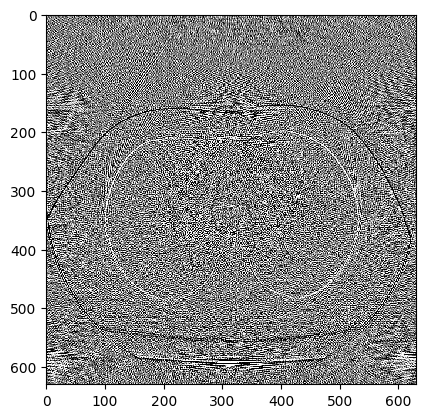

In [12]:
import cupy as cp
from ct_projector.projector.cupy.parallel import distance_driven_fp, distance_driven_bp, ramp_filter

cuimg = cp.array(img, order='C')[:, cp.newaxis, :, :]
cuangles = cp.array(angles, order='C')
cufp_ref = distance_driven_fp(projector, cuimg, cuangles)

fp_ref = cufp_ref.get()
fp_ref = fp_ref[..., np.newaxis]
plt.figure()
plt.imshow(fp_ref[fp_ref.shape[0] // 2, :, 0, :, 0], 'gray', vmin=0, vmax=10)

cufprj_ref = ramp_filter(projector, cufp_ref, 'RL')

cubp_ref = distance_driven_bp(projector, cufprj_ref, cuangles, is_fbp=True)
bp_ref = cubp_ref.get()
bp_ref = bp_ref[..., np.newaxis]
plt.figure()
plt.imshow(bp_ref[bp_ref.shape[0] // 2, 0, :, :, 0], 'gray', vmin=vmin, vmax=vmax)

plt.figure()
plt.imshow((bp - bp_ref)[bp_ref.shape[0] // 2, 0, :, :, 0], 'gray', vmin=-0.001, vmax=0.001)

print(np.abs(fp - fp_ref).max())
print(np.abs(bp - bp_ref).max())